In [1]:
import numpy as np
from numpy import (savez,load,save)
import pandas as pd
from pandas.plotting import lag_plot
import geopandas as gpd

import urllib.request
import urllib.parse 
import re

import calendar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import json

from bokeh.io import output_file, show
from bokeh.models import GeoJSONDataSource
from bokeh.plotting import figure
from bokeh.sampledata.sample_geojson import geojson

from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)

%matplotlib inline

In [ ]:
urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2021-01.csv", 
                           "yellow_tripdata_2021_01.csv")
df = pd.read_csv("yello_tripdata_2021_01.csv", cache_dates=True)

In [2]:
# load yellow taxi trip data
df = pd.read_csv("yellow_tripdata_2021-01.csv", cache_dates=True, low_memory=False)
# load taxi zone dictionary
zonelookup = "taxi+_zone_lookup.csv"
zones = pd.read_csv(zonelookup)
# load NYC taxi zone map
mypath = '~/Documents/'
geofile = mypath + 'NYCTaxiZones.geojson'
geodf = gpd.read_file(geofile)

In [3]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
df['day'] = df['tpep_pickup_datetime'].dt.day_name()
df['day'] = pd.Categorical(df['day'], 
                           categories= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
                           ordered=True)

df['hour'] = df['tpep_pickup_datetime'].dt.hour

df = df.dropna(how='any')

df = df[np.logical_and(df['tpep_pickup_datetime'] >= '2021-01-01', df['tpep_dropoff_datetime'] >= '2021-01-01' )]
df = df[np.logical_and(df['tpep_pickup_datetime'] <= '2021-01-31', df['tpep_dropoff_datetime'] <= '2021-01-31' )]

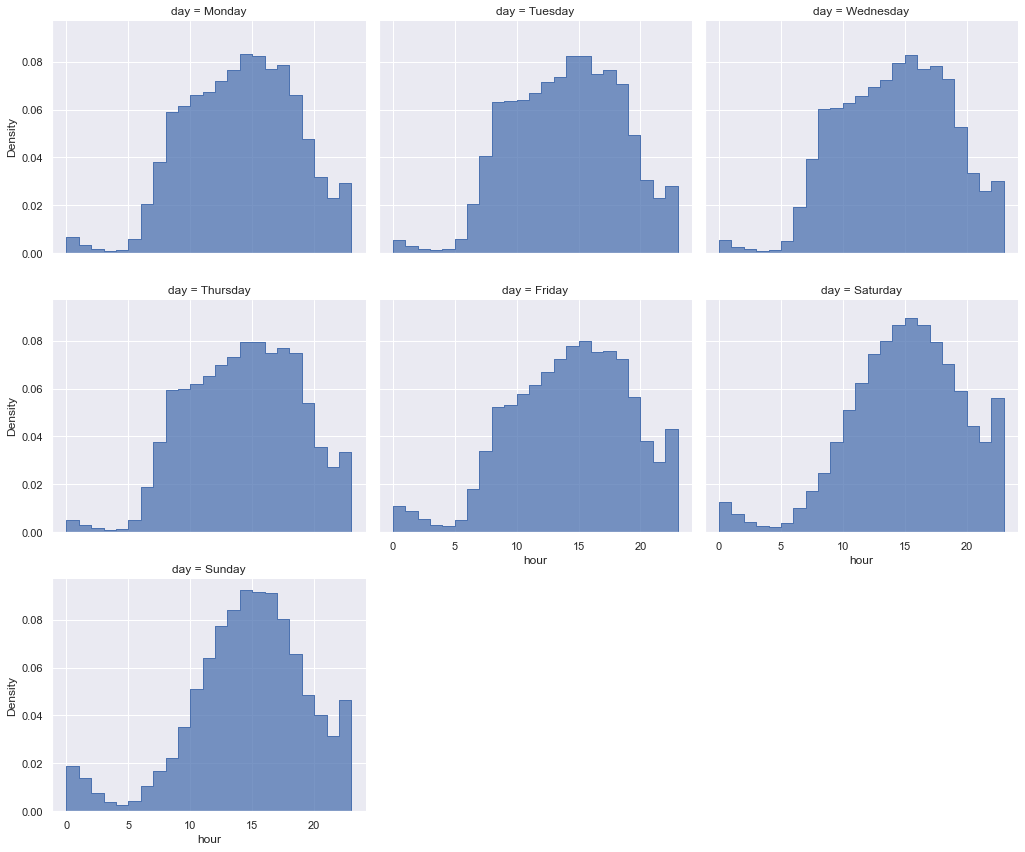

In [4]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df, col="day", height = 4, aspect = 1.2, col_wrap = 3)
g.map(sns.histplot, "hour", binwidth=1, stat='density', element="step")

In [5]:
# merge taxi pickup dataframe and taxi zone data
PU_df = pd.merge(df, zones, how='left', left_on=['PULocationID'], right_on = ['LocationID']).dropna()
#PU_df = PU_df.rename(columns={'Borough': 'PUborough', 'Zone': 'PUzone','service_zone':'PU_service_zone'})
PU_df = PU_df.rename(columns={'LocationID':'location_id'})
PU_df = PU_df.drop(columns = ['service_zone'])

# merge taxi dropoff dataframe and taxi zone data
DO_df = pd.merge(df, zones, how='left', left_on=['DOLocationID'], right_on=['LocationID']).dropna()
DO_df = DO_df.rename(columns={'LocationID':'location_id'})
DO_df = DO_df.drop(columns = ['service_zone'])

# tabulate the number of trips
PU_ct = PU_df.groupby(['location_id']).size().to_frame(name = 'numtrips')
DO_ct = DO_df.groupby(['location_id']).size().to_frame(name = 'numtrips')
#PU_ct['location_id'] = PU_ct.index
#DO_ct['location_id'] = DO_ct.index

# merge taxi pickup/dropoff dataframe and geo dataframe
PU_ct.index = PU_ct.index.astype('str')
DO_ct.index = DO_ct.index.astype('str')
PU = gpd.pd.merge(geodf, PU_ct, on='location_id', how='left').dropna()
DO = gpd.pd.merge(geodf, DO_ct, on='location_id', how='left').dropna()

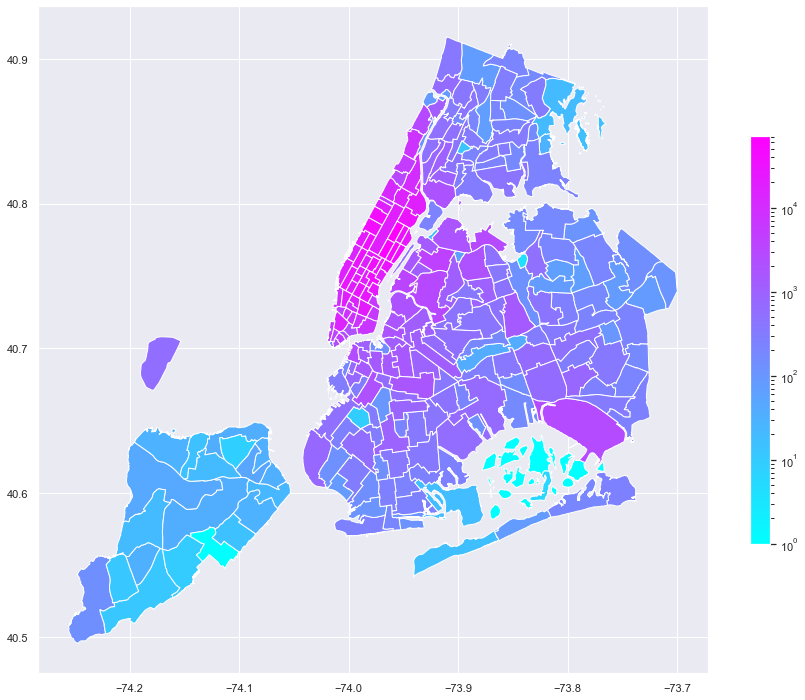

In [6]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = DO.plot(column='numtrips', cmap='cool', ax=ax, 
             norm=matplotlib.colors.LogNorm(vmin=PU.numtrips.min(), vmax=PU.numtrips.max()), 
             legend=True, legend_kwds={'shrink': 0.5})

plt.show()

In [7]:
PU_sum = PU_df.groupby(['tpep_pickup_datetime']).size().to_frame(name = 'numtrips')
df = PU_sum.resample('H').size().to_frame(name = 'numtrips')
df = df.rename_axis("datehour")

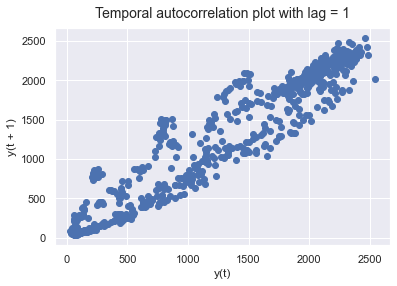

In [8]:
plt.figure()
pd.plotting.lag_plot(df['numtrips'], lag=1, c=None)
plt.title('Temporal autocorrelation plot with lag = 1',fontsize=14,pad=10)
plt.show()

Text(0, 0.5, 'number of trips')

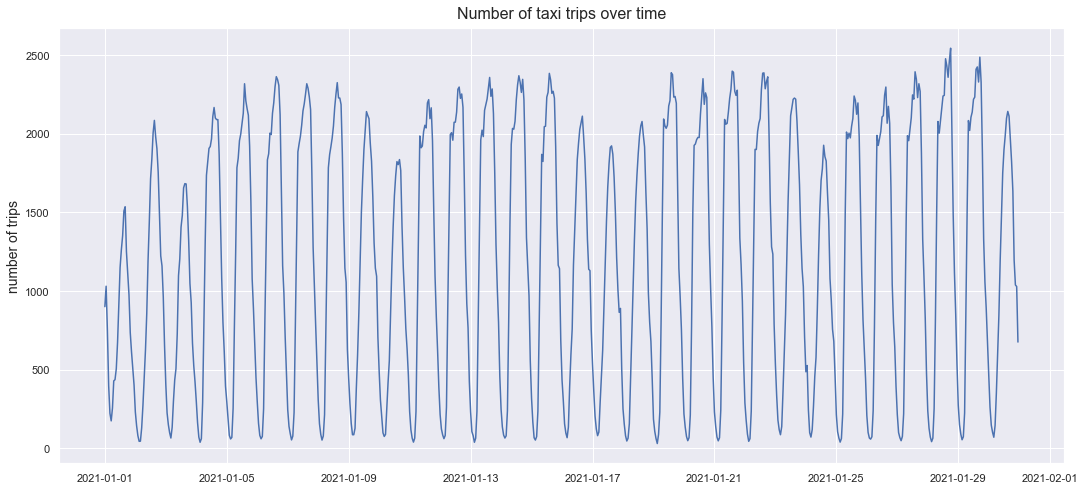

In [9]:
plt.plot(df.index, df['numtrips'])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 8)

plt.title("Number of taxi trips over time", pad=10, fontsize=16)
plt.ylabel("number of trips", fontsize=14)

In [10]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['numtrips']
test_data = test_data['numtrips']
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions, squared=False)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 173.80099520636753


[A Survey of Traffic Prediction: from Spatio‑Temporal Data to Intelligent Transportation](https://doi.org/10.1007/s41019-020-00151-z)
Yuan and Li, Data Science and Engineering (2021)

Table 3. Comparison of different traffic forecasting methods

| Problem Types | Techniques | Consider road network | Consider environmental data | Consider spatial property | Consider temporal property | Handle nonlinearity |
| --- | --- | --- | --- | --- | --- | --- | 
| OD travel | kNN | N | N | N | N | N | 
| OD travel | MLP | N | N | N | N | Y | 
| Time path | ResNet, LSTM, CNN | Y | Y | Y | Y | Y | 
| Time path | kNN, TD, regression | Y | N | N | N | N | 
| Travel time | DT, HMM | Y | N | N | N | Y | 
| Travel time | CNN, LSTM, W-D | Y | Y | Y | Y | Y | 
| Travel time | Generative | Y | N | N | N | Y | 
| Travel time | HA, ARIMA, ensemble | N | N | N | N | N | 
| Travel demand | MLP | N | Y | N | Y | N | 
| Travel demand | CNN+RNN | N | Y | Y | Y | Y |
| Travel demand | GCN, GAT | Y | Y | Y | Y | Y |
| Regional flow | HA, ARIMA, ensemble | N | N | N | N | N |
| Regional flow | CNN | N | Y | N | N | Y |
| Regional flow | CNN+LSTM | N | Y | N | N | Y |
| Network flow | Autoencoder | N | N | N | N | Y |
| Network flow | GCN, Attention | Y | N | N | N | Y |
| Network flow | GCN+RNN | Y | N | N | N | Y |
| Network flow | Metalearning | Y | N | Y | N | Y |
| Travel speed | HA, ARIMA | N | N | N | N | N | 
| Travel speed | CNN, LSTM, FNN | Y | N | N | N | Y | 
| Travel speed | LSTM+GCN | Y | Y | Y | Y | Y | 
